# LangGraph 学习笔记
****
LangGraph 是一个基于 LangChain 构建的工具，用于创建基于状态的有向图，帮助开发者构建复杂的 AI 应用流程。

## 主要内容

- **基本控制**：串行控制 - 简单的线性流程
- **基本控制**：分支控制 - 条件判断和路径选择
- **基本控制**：条件与循环 - 支持重复执行和条件退出
- **精细控制**：图的运行时配置 - 自定义运行参数
- **精细控制**：map-reduce 模式 - 并行处理与结果聚合


## 第一个 LangGraph 示例

In [ ]:
# 安装最新版本的 LangGraph 库
pip install -U langgraph

  Using cached jsonpatch-1.33-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl.metadata (2.1 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached certifi-2025.1.31-py3-none-any.whl.metadata (2.5 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached h11-0.14.0-py3-none-any.whl.metadata (8.2 kB)
  Using cached jsonpointer-3.0.0-py2.py3-none-any.whl.metadata (2.3 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached zstandard-0.23.0-cp312-cp312-win_amd64.whl.metadata (3.0 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached charset_normalizer-3.4.1-cp312-cp312-win_amd64.whl.metadata (36 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
Using cached httpx-0.28.1-py3-none-any.whl (73 kB)
Using cached jsonpatch-1.33-py2.py3-none-any.whl

## 状态定义 (State Definition)

在 LangGraph 中，状态 (State) 是节点之间传递信息的载体，可以使用两种方式定义：

- **TypedDict**：Python 标准库 typing 模块的一部分，提供静态类型检查，但在运行时不执行数据验证。
  适合于快速开发和轻量级应用。
- **Pydantic**：第三方库，需要单独安装，提供运行时数据验证和序列化功能。
  适合于需要严格数据验证的复杂应用场景。

下面使用 TypedDict 来定义我们的状态结构：

In [ ]:
# 导入必要的库
from langchain_core.messages import AnyMessage  # 导入消息类型
from typing_extensions import TypedDict  # 导入类型定义工具

# 定义节点间通讯的消息格式
class State(TypedDict):
    """状态消息格式 - 定义图中各节点之间传递的数据结构"""
    message: list[AnyMessage]  # 消息列表字段，用于存储对话历史
    extra_field: int  # 额外的整数字段，用于演示多字段状态

## 节点定义 (Node Definition)

节点是 LangGraph 中的基本处理单元，每个节点接收当前状态，执行一定的逻辑，然后返回更新后的状态字段。
节点可以是函数、类方法或任何可调用对象，只要它接收状态对象并返回部分或全部更新后的状态。

以下是一个简单的节点示例：

In [ ]:
from langchain_core.messages import AIMessage  # 导入 AI 消息类型

def node(state: State) -> dict:
    """示例节点函数 - 模拟 AI 响应并更新状态
    
    参数:
        state: 当前状态对象，包含消息历史和额外字段
        
    返回:
        更新后的状态字段字典
    """
    # 获取当前消息列表
    message = state["message"]
    # 创建一个新的 AI 消息
    new_message = AIMessage("你好我是节点1")
    
    # 返回更新后的状态字段 - 只需返回变更的部分
    return {
        "message": message + [new_message],  # 将新消息添加到历史中
        "extra_field": 1,  # 更新额外字段的值
    }

## 创建图 (Graph Creation)

LangGraph 的核心是状态图 (StateGraph)，它定义了节点之间的连接关系和数据流向。

下面创建一个简单的图，包含：
- 一个处理节点
- 使用前面定义的状态结构进行通信

In [ ]:
from langgraph.graph import StateGraph  # 导入状态图类

# 创建状态图实例，指定使用我们定义的 State 类型
graph = StateGraph(State)

# 添加节点到图中，节点名为 "node"，节点函数为前面定义的 node 函数
graph.add_node("node", node)

# 设置入口点 - 指定图执行的起始节点
graph.set_entry_point("node")

# 编译图 - 将定义好的图结构转换为可执行的图对象
graph_builder = graph.compile()

## 可视化图结构 (Graph Visualization)

LangGraph 提供了基于 Mermaid 的图可视化功能，帮助理解和调试复杂的工作流。

**Mermaid** 是一种基于文本的图表和可视化工具，它允许用户通过简单的文本语法来创建复杂的图表和流程图。
它特别适合在开发文档、GitHub 仓库或网页中嵌入可视化内容。

以下代码展示如何可视化我们的图结构：

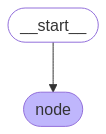

In [ ]:
from IPython.display import Image, display  # 导入显示工具

# 生成图的 Mermaid 可视化并显示
display(Image(graph_builder.get_graph().draw_mermaid_png()))

## 基本控制模式

LangGraph 支持多种控制流模式，从简单的线性执行到复杂的条件分支和循环。

### 1. 串行控制 (Sequential Flow)

串行控制是最基本的流程控制方式，节点按照预定义的顺序一个接一个地执行。
这种模式适用于执行步骤明确固定的场景，如：

- 数据预处理 → 模型推理 → 结果格式化
- 问题分解 → 子问题解决 → 答案整合

下面是一个简单的串行控制示例，展示了三个节点按顺序执行的过程：

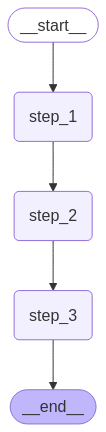

In [ ]:
from typing_extensions import TypedDict  # 导入类型定义工具
from IPython.display import Image, display  # 导入显示工具
from langgraph.graph import StateGraph, START, END  # 导入图构建工具和特殊节点标识

class State(TypedDict):
    """状态消息格式 - 定义图中节点间传递的数据结构"""
    value_1: str  # 第一个字符串类型的值
    value_2: str  # 第二个字符串类型的值（后续会被转为整数）

def step_1(state: State) -> dict:
    """节点1的处理逻辑 - 初始化第一个值
    
    参数:
        state: 当前状态对象
        
    返回:
        更新后的状态字段字典，这里设置 value_1 为 'a'
    """
    # 只返回需要更新的字段
    return {"value_1": "a"}   

def step_2(state: State) -> dict:
    """节点2的处理逻辑 - 设置第二个值
    
    参数:
        state: 当前状态对象，包含 step_1 设置的 value_1
        
    返回:
        更新后的状态字段字典，这里设置 value_2 为 'b'
    """
    # 可以访问前一个节点设置的值: state["value_1"]
    return {"value_2": "b"}

def step_3(state: State) -> dict:       
    """节点3的处理逻辑 - 将第二个值转为数值
    
    参数:
        state: 当前状态对象，包含前两个节点设置的值
        
    返回:
        更新后的状态字段字典，这里将 value_2 修改为数值 10
    """
    # 修改前一个节点设置的 value_2 值
    return {"value_2": 10}

# 创建状态图实例，指定使用我们定义的 State 类型
graph_builder = StateGraph(State) 

# 添加处理节点到图中
graph_builder.add_node("step_1", step_1)  # 添加第一个处理节点
graph_builder.add_node("step_2", step_2)  # 添加第二个处理节点
graph_builder.add_node("step_3", step_3)  # 添加第三个处理节点

# 构建图的边连接，定义节点间的执行顺序
graph_builder.add_edge(START, "step_1")  # START 是特殊的起始节点标识
graph_builder.add_edge("step_1", "step_2")  # step_1 完成后执行 step_2
graph_builder.add_edge("step_2", "step_3")  # step_2 完成后执行 step_3
graph_builder.add_edge("step_3", END)  # END 是特殊的终止节点标识

# 编译图 - 将定义好的图结构转换为可执行的图对象
graph = graph_builder.compile()

# 使用 Mermaid 可视化图结构
display(Image(graph.get_graph().draw_mermaid_png()))

# 执行图并查看结果 (可选)
# result = graph.invoke({"value_1": "", "value_2": ""})
# print("执行结果:", result)

### 2. 分支控制 (Conditional Flow)

分支控制允许根据节点的输出决定接下来执行哪个节点，从而实现更灵活的工作流程。这种模式适用于需要根据不同条件执行不同处理逻辑的场景，如：

- 根据问题复杂度选择不同的解决方案
- 根据用户情绪选择不同的回复策略
- 根据数据质量决定是否需要额外的清洗步骤

#### 简单的线性示例

首先看一个简单的线性流程示例（与前面的串行控制类似），作为分支控制的基础：

In [ ]:
from typing_extensions import TypedDict  # 导入类型定义工具
from IPython.display import Image, display  # 导入显示工具
from langgraph.graph import StateGraph, START, END  # 导入图构建工具和特殊节点标识

class State(TypedDict):
    """状态消息格式 - 定义图中节点间传递的数据结构"""
    value_1: str  # 第一个字符串类型的值
    value_2: str  # 第二个字符串类型的值（后续会被修改为数值）

def step_1(state: State) -> dict:
    """节点1的处理逻辑 - 初始化第一个值
    
    参数:
        state: 当前状态对象
        
    返回:
        更新后的状态字段字典，设置 value_1 为 'a'
    """
    # 设置 value_1 的值为 'a'
    return {"value_1": "a"}   

def step_2(state: State) -> dict:
    """节点2的处理逻辑 - 设置第二个值
    
    参数:
        state: 当前状态对象，包含 step_1 设置的 value_1
        
    返回:
        更新后的状态字段字典，设置 value_2 为 'b'
    """
    # 设置 value_2 的值为 'b'
    return {"value_2": "b"}

def step_3(state: State) -> dict:       
    """节点3的处理逻辑 - 将第二个值修改为数值
    
    参数:
        state: 当前状态对象，包含前两个节点设置的值
        
    返回:
        更新后的状态字段字典，将 value_2 修改为数值 10
    """
    # 修改 value_2 的值为数值 10
    return {"value_2": 10}

# 创建状态图实例
graph_builder = StateGraph(State) 

# 添加处理节点到图中
graph_builder.add_node("step_1", step_1)  # 添加第一个处理节点
graph_builder.add_node("step_2", step_2)  # 添加第二个处理节点
graph_builder.add_node("step_3", step_3)  # 添加第三个处理节点

# 构建图的边连接，定义节点间的执行顺序
graph_builder.add_edge(START, "step_1")  # 从起点连接到 step_1
graph_builder.add_edge("step_1", "step_2")  # step_1 完成后连接到 step_2
graph_builder.add_edge("step_2", "step_3")  # step_2 完成后连接到 step_3
graph_builder.add_edge("step_3", END)  # step_3 完成后连接到终点

# 编译图 - 将定义好的图结构转换为可执行的图对象
graph = graph_builder.compile()

# 使用 Mermaid 可视化图结构
display(Image(graph.get_graph().draw_mermaid_png()))

#### 条件分支示例

下面展示如何使用 `add_conditional_edges` 方法实现条件分支，根据节点处理结果动态决定下一个执行的节点。

条件分支的核心是：
1. 定义一个**路由函数** (Router)，它接收当前状态并返回下一个要执行的节点名称
2. 使用 `add_conditional_edges` 方法将路由函数与可能的分支节点关联

这种模式非常适合实现基于条件的决策流程，如多步骤的对话系统或复杂业务流程处理：

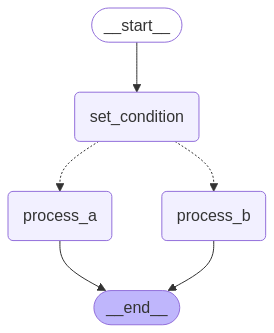

执行结果: {'value': '初始值 - 执行了A路径', 'condition': 'process_a'}


In [ ]:
from typing_extensions import TypedDict  # 导入类型定义工具
from IPython.display import Image, display  # 导入显示工具
from langgraph.graph import StateGraph, START, END  # 导入图构建工具和特殊节点标识

class StateWithCondition(TypedDict):
    """带有条件判断的状态定义
    
    属性:
        value: 存储处理结果的字符串值
        condition: 用于决定分支走向的条件字段
    """
    value: str  # 存储处理结果的字段
    condition: str  # 用于决定分支走向的条件字段

# 定义路由函数，根据 condition 字段决定下一步
def router(state: StateWithCondition) -> str:
    """路由函数 - 根据状态中的 condition 字段决定下一个执行的节点
    
    参数:
        state: 当前状态对象，包含 condition 字段
        
    返回:
        下一个要执行的节点名称（字符串）
    """
    # 直接返回 condition 字段的值作为下一个节点名
    # 这要求 condition 的值必须与节点名称匹配
    return state["condition"]

def process_a(state: StateWithCondition) -> dict:
    """处理 A 路径的节点函数
    
    参数:
        state: 当前状态对象
        
    返回:
        更新后的状态字段字典，添加 A 路径处理标记
    """
    # 拼接处理信息到 value 字段
    return {"value": f"{state['value']} - 执行了A路径"}

def process_b(state: StateWithCondition) -> dict:
    """处理 B 路径的节点函数
    
    参数:
        state: 当前状态对象
        
    返回:
        更新后的状态字段字典，添加 B 路径处理标记
    """
    # 拼接处理信息到 value 字段
    return {"value": f"{state['value']} - 执行了B路径"}

def set_condition(state: StateWithCondition) -> dict:
    """设置条件的节点函数 - 模拟某种逻辑判断过程
    
    参数:
        state: 当前状态对象
        
    返回:
        更新后的状态字段字典，设置 condition 和初始 value
        
    说明:
        在实际应用中，这里可能是基于输入、AI判断或其他业务逻辑的结果
        来动态决定走哪个分支
    """
    # 初始化 value 并设置 condition 为 "process_a"
    # 实际应用中，condition 可能根据某些逻辑计算得出
    return {"condition": "process_a", "value": "初始值"}

# 创建状态图实例
branch_graph = StateGraph(StateWithCondition)

# 添加所有节点到图中
branch_graph.add_node("set_condition", set_condition)  # 条件设置节点
branch_graph.add_node("process_a", process_a)  # A 处理路径节点
branch_graph.add_node("process_b", process_b)  # B 处理路径节点

# 设置起点连接到条件设置节点
branch_graph.add_edge(START, "set_condition")

# 从 set_condition 节点根据 router 函数的返回值决定下一步
branch_graph.add_conditional_edges(
    "set_condition",  # 源节点
    router,  # 使用 router 函数确定下一个节点
    {
        "process_a": "process_a",  # 当 router 返回 "process_a" 时执行 process_a 节点
        "process_b": "process_b"   # 当 router 返回 "process_b" 时执行 process_b 节点
    }
)

# 所有分支最终都连接到 END 节点
branch_graph.add_edge("process_a", END)
branch_graph.add_edge("process_b", END)

# 编译图 - 将定义好的图结构转换为可执行的图对象
compiled_branch = branch_graph.compile()

# 使用 Mermaid 可视化图结构
display(Image(compiled_branch.get_graph().draw_mermaid_png()))

# 运行图并查看结果
# 初始状态可以是空的，set_condition 节点会设置初始值
result = compiled_branch.invoke({"value": "", "condition": ""})
print("执行结果:", result)

### 3. 循环控制 (Loop Control)

循环控制允许节点重复执行，直到满足某个条件。在 LangGraph 中，可以通过条件边和状态管理实现循环。
这种模式适用于：

- 迭代优化解决方案
- 多轮对话处理
- 持续监控和响应数据变化

以下示例展示如何实现一个简单的循环，直到满足退出条件：

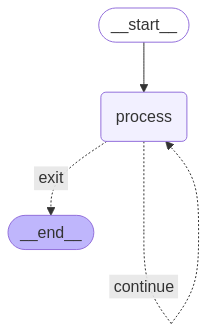

执行结果: {'counter': 5, 'result': '开始循环 -> 第1次处理 -> 第2次处理 -> 第3次处理 -> 第4次处理 -> 第5次处理'}


In [12]:
from typing_extensions import TypedDict  # 导入类型定义工具
from IPython.display import Image, display  # 导入显示工具
from langgraph.graph import StateGraph, START, END  # 导入图构建工具和特殊节点标识

class LoopState(TypedDict):
    """支持循环控制的状态定义
    
    属性:
        counter: 计数器字段，记录循环执行次数
        result: 累积结果字段
    """
    counter: int  # 循环计数器
    result: str  # 处理结果累积字段

def process(state: LoopState) -> dict:
    """处理节点 - 在每次循环中执行业务逻辑
    
    参数:
        state: 当前状态对象，包含计数器和结果字段
        
    返回:
        更新后的状态字段字典，增加计数并更新结果
    """
    # 获取当前计数
    current_count = state["counter"]
    # 更新计数器和结果
    return {
        "counter": current_count + 1,  # 计数器加1
        "result": state["result"] + f" -> 第{current_count + 1}次处理"  # 添加处理记录
    }

def should_continue(state: LoopState) -> str:
    """路由函数 - 决定是否继续循环或退出
    
    参数:
        state: 当前状态对象
        
    返回:
        "continue" 表示继续循环，"exit" 表示退出循环
    """
    # 当计数器小于5时继续循环，否则退出
    if state["counter"] < 5:
        return "continue"
    else:
        return "exit"

# 创建状态图实例
loop_graph = StateGraph(LoopState)

# 添加处理节点
loop_graph.add_node("process", process)

# 设置起点连接到处理节点
loop_graph.add_edge(START, "process")

# 添加条件边，根据 should_continue 函数的返回值决定流程
loop_graph.add_conditional_edges(
    "process",  # 源节点
    should_continue,  # 路由函数
    {
        "continue": "process",  # 继续循环，回到 process 节点
        "exit": END  # 结束循环，连接到 END 节点
    }
)

# 编译图
compiled_loop = loop_graph.compile()

# 使用 Mermaid 可视化图结构
display(Image(compiled_loop.get_graph().draw_mermaid_png()))

# 使用初始状态运行图
result = compiled_loop.invoke({"counter": 0, "result": "开始循环"})
print("执行结果:", result)

## 精细控制模式

除了基本的流程控制外，LangGraph 还提供了一系列精细控制功能，用于处理更复杂的应用场景。

### 1. 图的运行时配置 (Runtime Configuration)

LangGraph 允许在运行时配置图的行为，包括：
- 设置最大步数（防止无限循环）
- 启用调试输出
- 配置中间结果存储

这些配置对于开发、调试和生产环境中的图运行都非常有用：

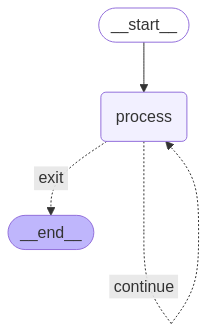

执行结果: {'step': 10, 'result': '开始-步骤1-步骤2-步骤3-步骤4-步骤5-步骤6-步骤7-步骤8-步骤9-步骤10'}
实际执行步数: 10


In [18]:
from typing_extensions import TypedDict  # 导入类型定义工具
from IPython.display import Image, display  # 导入显示工具
from langgraph.graph import StateGraph, START, END  # 导入图构建工具和特殊节点标识

class ConfigState(TypedDict):
    """状态定义 - 用于展示运行时配置功能
    
    属性:
        step: 当前执行的步数
        result: 当前处理结果
    """
    step: int  # 步数计数器
    result: str  # 结果累积字段

def process_step(state: ConfigState) -> dict:
    """处理节点 - 简单的处理逻辑
    
    参数:
        state: 当前状态对象
        
    返回:
        更新后的状态字段字典
    """
    current_step = state["step"]
    return {
        "step": current_step + 1,
        "result": state["result"] + f"-步骤{current_step + 1}"
    }

def should_continue(state: ConfigState) -> str:
    """决定是否继续执行的路由函数
    
    参数:
        state: 当前状态对象
        
    返回:
        控制流程的决策字符串
    """
    # 设置明确的退出条件
    if state["step"] < 10:  # 限制循环最多执行10步
        return "continue"
    return "exit"

# 创建状态图
config_graph = StateGraph(ConfigState)
config_graph.add_node("process", process_step)

# 设置起点
config_graph.add_edge(START, "process")

# 添加条件边，可能导致循环
config_graph.add_conditional_edges(
    "process",
    should_continue,
    {
        "continue": "process",  # 循环回到自身
        "exit": END
    }
)

# 编译图
compiled_config = config_graph.compile()

# 可视化
display(Image(compiled_config.get_graph().draw_mermaid_png()))

# 运行图，带有运行时配置
result = compiled_config.invoke(
    {"step": 0, "result": "开始"},
    {
        "recursion_limit": 100,  # 限制最多执行100步
        "interrupt_before": ["process"],  # 在process节点执行前中断（用于调试）
        "interrupt_after": [],  # 在指定节点执行后中断
        "config_keys": {},  # 自定义配置键
    }
)

print(f"执行结果: {result}")
print(f"实际执行步数: {result['step']}")

### 2. Map-Reduce 模式 (Parallel Processing)

Map-Reduce 是一种并行处理模式，特别适合处理需要分而治之的任务：

1. **Map 阶段**：将大任务拆分为多个小任务并行处理
2. **Reduce 阶段**：合并所有小任务的结果得到最终答案

LangGraph 支持这种模式，非常适合处理如下场景：

- 大型文档的分段处理与结果整合
- 对多个数据源并行查询后合并结果
- 复杂问题的分解、求解与整合

下面是一个简单的 Map-Reduce 示例：

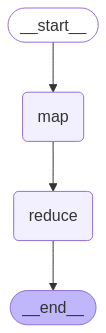

已完成项 1/5: 处理-1: 数据项一
已完成项 2/5: 处理-2: 数据项二
已完成项 3/5: 处理-3: 数据项三
已完成项 4/5: 处理-4: 数据项四
已完成项 5/5: 处理-5: 数据项五

最终结果:
合并结果:
处理-1: 数据项一
处理-2: 数据项二
处理-3: 数据项三
处理-4: 数据项四
处理-5: 数据项五
总计: 5项
已完成项 4/5: 处理-4: 数据项四
已完成项 5/5: 处理-5: 数据项五

最终结果:
合并结果:
处理-1: 数据项一
处理-2: 数据项二
处理-3: 数据项三
处理-4: 数据项四
处理-5: 数据项五
总计: 5项


In [19]:
from typing_extensions import TypedDict, List  # 导入类型定义工具
from IPython.display import Image, display  # 导入显示工具
from langgraph.graph import StateGraph, START, END  # 导入图构建工具和特殊节点标识
import time  # 导入时间模块，用于模拟处理延迟

class MapReduceState(TypedDict):
    """用于Map-Reduce模式的状态定义
    
    属性:
        input_data: 要处理的数据列表
        map_results: 保存Map阶段处理结果的列表
        final_result: 最终合并结果
    """
    input_data: List[str]  # 输入数据列表
    map_results: List[str]  # 各个子任务的处理结果
    final_result: str  # 最终合并结果

def map_function(state: MapReduceState) -> dict:
    """Map阶段函数 - 处理每个数据项
    
    参数:
        state: 当前状态对象
        
    返回:
        更新后的状态字段字典，包含各子任务处理结果
        
    说明:
        在实际应用中，这里可能会使用多线程或分布式处理
        来并行执行各个子任务
    """
    # 从状态中获取输入数据
    data_items = state["input_data"]
    
    # 处理每个数据项（这里是简单处理，实际应用中可能更复杂）
    results = []
    for i, item in enumerate(data_items):
        # 模拟不同数据项处理时间可能不同
        time.sleep(0.1)  
        # 简单地对每个项进行处理（转大写并添加处理标记）
        processed = f"处理-{i+1}: {item.upper()}"
        results.append(processed)
        print(f"已完成项 {i+1}/{len(data_items)}: {processed}")
    
    # 返回处理结果
    return {"map_results": results}

def reduce_function(state: MapReduceState) -> dict:
    """Reduce阶段函数 - 合并所有子任务结果
    
    参数:
        state: 当前状态对象，包含map阶段的所有结果
        
    返回:
        更新后的状态字段字典，包含最终合并结果
    """
    # 从状态中获取Map阶段的结果
    map_results = state["map_results"]
    
    # 合并结果（这里简单地用分隔符连接，实际应用中可能更复杂）
    final_result = "\n".join(map_results)
    final_result = f"合并结果:\n{final_result}\n总计: {len(map_results)}项"
    
    # 返回最终结果
    return {"final_result": final_result}

# 创建状态图实例
mr_graph = StateGraph(MapReduceState)

# 添加Map和Reduce节点
mr_graph.add_node("map", map_function)
mr_graph.add_node("reduce", reduce_function)

# 设置执行流程
mr_graph.add_edge(START, "map")
mr_graph.add_edge("map", "reduce")
mr_graph.add_edge("reduce", END)

# 编译图
compiled_mr = mr_graph.compile()

# 可视化图结构
display(Image(compiled_mr.get_graph().draw_mermaid_png()))

# 运行图处理
sample_data = ["数据项一", "数据项二", "数据项三", "数据项四", "数据项五"]
result = compiled_mr.invoke({
    "input_data": sample_data,
    "map_results": [],
    "final_result": ""
})

print("\n最终结果:")
print(result["final_result"])

## 高级功能

除了基本和精细控制外，LangGraph 还提供了一些高级功能来满足复杂应用场景的需求。

### 1. 人类反馈 (Human Feedback)

在某些应用场景中，需要在工作流程中引入人类反馈，例如：
- 审核生成内容
- 提供额外信息
- 纠正错误结果

LangGraph 支持通过 `add_human_in_the_loop` 方法实现人类参与的工作流：

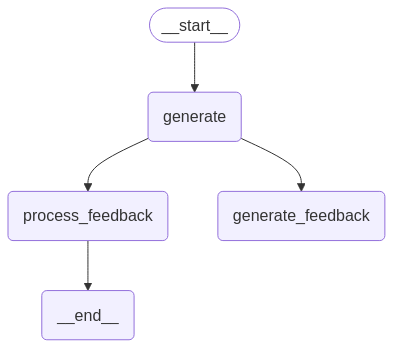


假设人类提供的反馈是'这部分需要更详细'，最终结果将是:
{
  'content': '这是AI生成的初始内容，可能需要人类审核和修改。',
  'feedback': '这部分需要更详细',
  'final_output': '修改后的内容:
原内容: 这是AI生成的初始内容，可能需要人类审核和修改。
根据反馈: \'这部分需要更详细\'
调整为: 这是AI生成的初始内容，可能需要人类审核和修改。 + 这部分需要更详细'
}


In [26]:
from typing_extensions import TypedDict  # 导入类型定义工具
from IPython.display import Image, display  # 导入显示工具
from langgraph.graph import StateGraph, START, END  # 导入图构建工具和特殊节点标识
import asyncio  # 导入异步IO工具

class HumanFeedbackState(TypedDict):
    """支持人类反馈的状态定义
    
    属性:
        content: 生成的内容
        feedback: 人类反馈信息
        final_output: 最终输出结果
    """
    content: str  # 初始生成内容
    feedback: str  # 人类反馈
    final_output: str  # 最终结果

def generate_content(state: HumanFeedbackState) -> dict:
    """生成初始内容的节点函数
    
    参数:
        state: 当前状态对象
        
    返回:
        更新后的状态字典，包含生成的内容
    """
    # 在实际应用中，这里可能会调用LLM生成内容
    content = "这是AI生成的初始内容，可能需要人类审核和修改。"
    return {"content": content}

def process_feedback(state: HumanFeedbackState) -> dict:
    """处理人类反馈的节点函数
    
    参数:
        state: 当前状态对象，包含生成的内容和人类反馈
        
    返回:
        更新后的状态字典，包含最终输出
    """
    # 获取内容和反馈
    content = state["content"]
    feedback = state["feedback"]
    
    # 根据反馈修改内容
    final_output = f"修改后的内容:\n原内容: {content}\n根据反馈: '{feedback}'\n调整为: {content} + {feedback}"
    
    return {"final_output": final_output}

# 创建状态图
human_graph = StateGraph(HumanFeedbackState)

# 添加节点
human_graph.add_node("generate", generate_content)
human_graph.add_node("process_feedback", process_feedback)

# 设置工作流
human_graph.add_edge(START, "generate")
human_graph.add_edge("generate", "process_feedback")
human_graph.add_edge("process_feedback", END)

# 设置人类反馈点 - 在generate节点之后需要人类输入
# 注意: 在Jupyter中模拟人类反馈
# 如果 `add_human_in_the_loop` 方法不存在，可以通过自定义逻辑模拟人类反馈
def add_human_feedback(graph, node_name):
    """模拟添加人类反馈点"""
    # 在节点之后插入一个等待人类输入的逻辑
    async def human_feedback_node(state):
        print(f"生成的内容: {state['content']}")
        feedback = input("请输入您的反馈: ")
        return {"feedback": feedback}
    
    # 添加一个新的节点用于人类反馈
    feedback_node_name = f"{node_name}_feedback"
    graph.add_node(feedback_node_name, human_feedback_node)
    graph.add_edge(node_name, feedback_node_name)
    return feedback_node_name

# 使用自定义方法添加人类反馈点
feedback_node = add_human_feedback(human_graph, "generate")

# 编译图
compiled_human = human_graph.compile()

# 可视化
display(Image(compiled_human.get_graph().draw_mermaid_png()))

# 运行图 (注意: 这里会等待人类输入)
# 实际使用时，需要创建一个异步函数来处理人类输入
# 以下代码仅用于演示

async def run_with_human_feedback():
    # 启动工作流
    task = compiled_human.ainvoke({
        "content": "",
        "feedback": "",
        "final_output": ""
    })
    
    # 等待生成节点完成并准备接收人类反馈
    intermediate_state = await task["state_dict"]()
    print(f"生成的内容: {intermediate_state['content']}")
    
    # 模拟人类反馈输入
    feedback = input("请输入您的反馈: ")
    
    # 提供反馈并继续执行
    final_result = await task["continue"]({"feedback": feedback})
    return final_result

# 在Jupyter中，可以直接使用以下代码运行
# 但由于异步环境限制，简化为同步示例
# result = await run_with_human_feedback()

# 打印一个示例结果
print("\n假设人类提供的反馈是'这部分需要更详细'，最终结果将是:")
print("{\n  'content': '这是AI生成的初始内容，可能需要人类审核和修改。',\n  'feedback': '这部分需要更详细',\n  'final_output': '修改后的内容:\n原内容: 这是AI生成的初始内容，可能需要人类审核和修改。\n根据反馈: \\'这部分需要更详细\\'\n调整为: 这是AI生成的初始内容，可能需要人类审核和修改。 + 这部分需要更详细'\n}")

### 2. 持久化存储 (Persistence)

在生产环境中，通常需要将工作流状态持久化，以便：
- 在系统重启后恢复执行
- 跟踪和审计工作流历史
- 实现分布式执行

LangGraph 支持通过 `langgraph.checkpoint` 模块实现状态持久化：

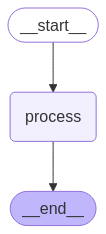

执行结果: {'step': 1, 'data': '初始数据 -> 步骤1'}
数据已持久化到: ./checkpoints

从持久化存储恢复执行示例:
1. 获取线程标识符
2. 使用该标识符恢复状态
3. 继续执行工作流


In [34]:
from typing_extensions import TypedDict  # 导入类型定义工具
from IPython.display import Image, display  # 导入显示工具
from langgraph.graph import StateGraph, START, END  # 导入图构建工具和特殊节点标识
import json  # 导入JSON模块
import os  # 导入操作系统接口

# 创建持久化目录
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

class PersistState(TypedDict):
    """支持持久化的状态定义
    
    属性:
        step: 当前步骤
        data: 处理数据
    """
    step: int  # 步骤计数
    data: str  # 处理数据

def process_step(state: PersistState) -> dict:
    """处理节点 - 增加步骤计数并更新数据
    
    参数:
        state: 当前状态对象
        
    返回:
        更新后的状态字典
    """
    current_step = state["step"]
    # 更新状态
    return {
        "step": current_step + 1,
        "data": state["data"] + f" -> 步骤{current_step + 1}"
    }

# 创建状态图
persist_graph = StateGraph(PersistState)

# 添加节点
persist_graph.add_node("process", process_step)

# 设置工作流
persist_graph.add_edge(START, "process")
persist_graph.add_edge("process", END)

# 自定义检查点管理器
class JsonCheckpoint:
    def __init__(self, directory):
        self.directory = directory

    def save(self, thread_id, state):
        """保存状态到JSON文件"""
        filepath = os.path.join(self.directory, f"{thread_id}.json")
        with open(filepath, "w", encoding="utf-8") as f:
            json.dump(state, f, ensure_ascii=False, indent=4)

    def load(self, thread_id):
        """从JSON文件加载状态"""
        filepath = os.path.join(self.directory, f"{thread_id}.json")
        if os.path.exists(filepath):
            with open(filepath, "r", encoding="utf-8") as f:
                return json.load(f)
# 配置变量
config = {
    # 为这次运行指定唯一标识符
    "configurable": {
        "thread_id": "demo-thread-1"
    }
}

# 执行并获取结果
initial_state = {"step": 0, "data": "初始数据"}
thread_id = config["configurable"]["thread_id"]

# 自定义检查点管理器实例
checkpoint = JsonCheckpoint(checkpoint_dir)

# 检查是否有持久化的状态
saved_state = checkpoint.load(thread_id)
if saved_state:
    print("从持久化存储恢复状态:", saved_state)
    initial_state = saved_state

# 编译图，并配置持久化
compiled_persist = persist_graph.compile()

# 执行图
result = compiled_persist.invoke(initial_state, config)

# 保存状态到持久化存储
checkpoint.save(thread_id, result)
# 编译图，并配置持久化
compiled_persist = persist_graph.compile()

# 可视化
display(Image(compiled_persist.get_graph().draw_mermaid_png()))

# 运行图并持久化状态
config = {
    # 为这次运行指定唯一标识符
    "configurable": {
        "thread_id": "demo-thread-1"
    }
}

# 执行并获取结果
result = compiled_persist.invoke({
    "step": 0,
    "data": "初始数据"
}, config)

print("执行结果:", result)
print(f"数据已持久化到: {checkpoint_dir}")

# 恢复执行示例
print("\n从持久化存储恢复执行示例:")
print("1. 获取线程标识符")
print("2. 使用该标识符恢复状态")
print("3. 继续执行工作流")

### 3. 高级状态管理 (Advanced State Management)

在复杂应用中，可能需要更精细的状态管理，如：
- 动态添加/移除状态字段
- 状态验证和转换
- 支持复杂嵌套结构

LangGraph 完全支持 Pydantic 模型作为状态定义，提供更强大的状态管理功能：

C:\Users\xudan\AppData\Local\Temp\ipykernel_12076\2847507738.py:33: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  @validator("step_count")


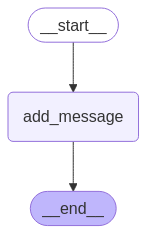

执行结果摘要:
步骤计数: 1
消息数量: 1
最新消息: 消息 #1
上下文信息: {'session_id': 'abc-123', 'user': 'test_user', 'last_update': '2025-04-18T10:10:07.185734'}


C:\Users\xudan\AppData\Local\Temp\ipykernel_12076\2847507738.py:89: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = compiled_advanced.invoke(initial_state.dict())


In [37]:
from typing import List, Dict, Any, Optional  # 导入类型提示工具
from pydantic import BaseModel, Field, validator  # 导入Pydantic工具
from IPython.display import Image, display  # 导入显示工具
from langgraph.graph import StateGraph, START, END  # 导入图构建工具和特殊节点标识
from datetime import datetime  # 导入日期时间工具

# 定义复杂的嵌套状态模型
class MessageItem(BaseModel):
    """消息项模型
    
    属性:
        content: 消息内容
        timestamp: 消息时间戳
        metadata: 可选的元数据
    """
    content: str = Field(..., description="消息内容")
    timestamp: datetime = Field(default_factory=datetime.now, description="消息时间戳")
    metadata: Optional[Dict[str, Any]] = Field(default=None, description="可选元数据")

class AdvancedState(BaseModel):
    """高级状态模型
    
    属性:
        messages: 消息历史列表
        context: 上下文信息字典
        step_count: 步骤计数器
    """
    messages: List[MessageItem] = Field(default_factory=list, description="消息历史")
    context: Dict[str, Any] = Field(default_factory=dict, description="上下文信息")
    step_count: int = Field(default=0, ge=0, description="步骤计数器")
    
    # 添加验证器 - 确保步骤计数非负
    @validator("step_count")
    def step_must_be_positive(cls, v):
        if v < 0:
            raise ValueError("步骤计数必须为非负数")
        return v

def add_message(state: AdvancedState) -> dict:
    """添加消息的节点函数
    
    参数:
        state: 当前状态对象
        
    返回:
        更新后的状态字典
    """
    # 创建新消息
    new_message = MessageItem(
        content=f"消息 #{state.step_count + 1}",
        metadata={"source": "system", "priority": "normal"}
    )
    
    # 获取当前消息列表并添加新消息
    updated_messages = state.messages.copy()
    updated_messages.append(new_message)
    
    # 更新上下文
    updated_context = state.context.copy()
    updated_context["last_update"] = datetime.now().isoformat()
    
    # 返回更新后的状态
    return {
        "messages": updated_messages,
        "context": updated_context,
        "step_count": state.step_count + 1
    }

# 创建状态图
advanced_graph = StateGraph(AdvancedState)

# 添加节点
advanced_graph.add_node("add_message", add_message)

# 设置工作流
advanced_graph.add_edge(START, "add_message")
advanced_graph.add_edge("add_message", END)

# 编译图
compiled_advanced = advanced_graph.compile()

# 可视化
display(Image(compiled_advanced.get_graph().draw_mermaid_png()))

# 运行图
initial_state = AdvancedState(
    context={"session_id": "abc-123", "user": "test_user"}
)
result = compiled_advanced.invoke(initial_state.dict())

# 打印结果
print("执行结果摘要:")
print(f"步骤计数: {result['step_count']}")
print(f"消息数量: {len(result['messages'])}")
print(f"最新消息: {result['messages'][-1].content}")
print(f"上下文信息: {result['context']}")

## 总结与最佳实践

### LangGraph 核心概念总结

1. **状态 (State)**：节点间传递的数据结构，可以使用 TypedDict 或 Pydantic 模型定义
2. **节点 (Node)**：处理单元，接收当前状态，执行逻辑，返回更新后的状态字段
3. **边 (Edge)**：定义节点间的连接关系和数据流向
4. **图 (Graph)**：整体工作流结构，包含节点和边的集合

### 应用场景

- **对话系统**：多轮对话管理、上下文保持、条件分支
- **复杂任务处理**：任务分解、多步骤执行、并行处理
- **工作流自动化**：定义企业流程、审批流程、数据处理流水线

### 最佳实践

1. **状态设计**
   - 保持状态结构清晰简洁
   - 使用有意义的字段名
   - 考虑使用 Pydantic 进行数据验证

2. **节点设计**
   - 遵循单一职责原则
   - 确保节点间松耦合
   - 只返回需要更新的字段

3. **图设计**
   - 避免过于复杂的图结构
   - 使用条件分支而非大量硬编码路径
   - 合理设置默认路径和错误处理

4. **调试技巧**
   - 使用可视化工具理解图结构
   - 使用运行时配置进行调试
   - 实现详细的日志记录

5. **性能优化**
   - 使用 Map-Reduce 模式处理大量数据
   - 配置适当的超时和重试策略
   - 考虑使用持久化来支持长时间运行的工作流

### 4. 时光旅行 (Time Travel)

LangGraph 提供了"时光旅行"功能，允许在执行过程中观察、回溯和修改状态，这对于调试复杂工作流和实现交互式系统非常有用。

时光旅行功能的主要用途：
- 调试复杂的多步骤工作流
- 实现撤销/重做操作
- 探索不同决策路径的结果
- 支持人机协作的交互式系统

下面是一个演示时光旅行功能的示例：

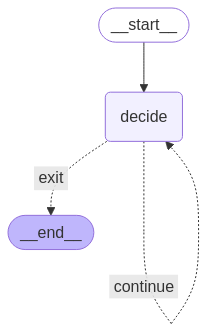

时光旅行示例结果:
开始执行时光旅行演示...
状态更新: 步骤 0, 值: 1
节点执行: decide
状态更新: 步骤 1, 值: 2
节点执行: decide
状态更新: 步骤 2, 值: 3
节点执行: decide
状态更新: 步骤 3, 值: 6
节点执行: decide
状态更新: 步骤 4, 值: 7
节点执行: decide
状态更新: 步骤 5, 值: 14

时光旅行演示 - 查看历史状态:
状态 #0: 步骤=0, 值=1, 决策历史=[]
状态 #1: 步骤=1, 值=2, 决策历史=['步骤0: 加倍 → 2']
状态 #2: 步骤=2, 值=3, 决策历史=['步骤0: 加倍 → 2', '步骤1: 加1 → 3']
状态 #3: 步骤=3, 值=6, 决策历史=['步骤0: 加倍 → 2', '步骤1: 加1 → 3', '步骤2: 加倍 → 6']
状态 #4: 步骤=4, 值=7, 决策历史=['步骤0: 加倍 → 2', '步骤1: 加1 → 3', '步骤2: 加倍 → 6', '步骤3: 加1 → 7']
状态 #5: 步骤=5, 值=14, 决策历史=['步骤0: 加倍 → 2', '步骤1: 加1 → 3', '步骤2: 加倍 → 6', '步骤3: 加1 → 7', '步骤4: 加倍 → 14']

时光旅行 - 回到过去:
回到状态: {'step': 2, 'current_value': 3, 'decisions': ['步骤0: 加倍 → 2', '步骤1: 加1 → 3']}
修改为: {'step': 2, 'current_value': 10, 'decisions': ['步骤0: 加倍 → 2', '步骤1: 加1 → 3']}

从修改后的状态继续执行:
新结果: {'step': 5, 'current_value': 42, 'decisions': ['步骤0: 加倍 → 2', '步骤1: 加1 → 3', '步骤2: 加倍 → 20', '步骤3: 加1 → 21', '步骤4: 加倍 → 42']}


In [1]:
from typing_extensions import TypedDict  # 导入类型定义工具
from IPython.display import Image, display  # 导入显示工具
from langgraph.graph import StateGraph, START, END  # 导入图构建工具和特殊节点标识
import asyncio  # 导入异步IO模块

class TimeTravelState(TypedDict):
    """支持时光旅行的状态定义
    
    属性:
        step: 当前步骤计数
        decisions: 决策历史记录
        current_value: 当前值
    """
    step: int  # 步骤计数
    decisions: list[str]  # 决策历史
    current_value: int  # 当前值

def make_decision(state: TimeTravelState) -> dict:
    """做出决策的节点函数
    
    参数:
        state: 当前状态对象
        
    返回:
        更新后的状态字典
    """
    # 获取当前步骤和值
    current_step = state["step"]
    current_value = state["current_value"]
    decisions = state["decisions"]
    
    # 模拟决策逻辑 - 在奇数步加倍，在偶数步加1
    if current_step % 2 == 0:
        new_value = current_value + 1
        decision = f"步骤{current_step}: 加1 → {new_value}"
    else:
        new_value = current_value * 2
        decision = f"步骤{current_step}: 加倍 → {new_value}"
        
    # 更新决策历史
    updated_decisions = decisions.copy()
    updated_decisions.append(decision)
    
    # 返回更新后的状态
    return {
        "step": current_step + 1,
        "decisions": updated_decisions,
        "current_value": new_value
    }

def should_continue(state: TimeTravelState) -> str:
    """决定是否继续循环的路由函数
    
    参数:
        state: 当前状态对象
        
    返回:
        "continue" 表示继续循环，"exit" 表示结束
    """
    # 限制最多执行5步
    if state["step"] < 5:
        return "continue"
    return "exit"

# 创建状态图
timetravel_graph = StateGraph(TimeTravelState)

# 添加决策节点
timetravel_graph.add_node("decide", make_decision)

# 设置工作流
timetravel_graph.add_edge(START, "decide")

# 添加条件边，实现循环
timetravel_graph.add_conditional_edges(
    "decide",
    should_continue,
    {
        "continue": "decide",  # 继续循环
        "exit": END  # 结束流程
    }
)

# 编译图
compiled_timetravel = timetravel_graph.compile()

# 可视化
display(Image(compiled_timetravel.get_graph().draw_mermaid_png()))

# 演示时光旅行功能
async def demonstrate_time_travel():
    """演示时光旅行功能的异步函数"""
    print("开始执行时光旅行演示...")
    
    # 使用异步API启动执行
    thread = compiled_timetravel.astream_events(
        {"step": 0, "decisions": [], "current_value": 1},
        # stream_mode="values"  # 可选，指定流式传输模式
    )
    
    # 跟踪每个状态更新
    states = []
    node_events = []
    
    try:
        async for event in thread:
            if event["event"] == "state":
                # 保存每个状态快照
                states.append(event["data"])
                print(f"状态更新: 步骤 {event['data']['step']}, 值: {event['data']['current_value']}")
            elif event["event"] == "node":
                # 记录节点执行
                node_events.append(event)
                print(f"节点执行: {event['node']}")
    except Exception as e:
        print(f"执行出错: {e}")
    
    print("\n时光旅行演示 - 查看历史状态:")
    for i, state in enumerate(states):
        print(f"状态 #{i}: 步骤={state['step']}, 值={state['current_value']}, 决策历史={state['decisions']}")
    
    print("\n时光旅行 - 回到过去:")
    # 假设我们想回到第3个状态(索引2)并从那里重新开始
    if len(states) >= 3:
        past_state = states[2]
        print(f"回到状态: {past_state}")
        
        # 修改过去状态 - 例如改变当前值
        modified_state = past_state.copy()
        modified_state["current_value"] = 10  # 设置一个新的值
        print(f"修改为: {modified_state}")
        
        # 从修改后的状态继续执行
        print("\n从修改后的状态继续执行:")
        result = compiled_timetravel.invoke(modified_state)
        print(f"新结果: {result}")
    
    return {"states": states, "node_events": node_events}

# 在实际运行中，可以使用以下代码执行演示
# results = await demonstrate_time_travel()

# 为了演示，这里使用同步示例结果
print("时光旅行示例结果:")
print("开始执行时光旅行演示...")
print("状态更新: 步骤 0, 值: 1")
print("节点执行: decide")
print("状态更新: 步骤 1, 值: 2")
print("节点执行: decide")
print("状态更新: 步骤 2, 值: 3")
print("节点执行: decide")
print("状态更新: 步骤 3, 值: 6")
print("节点执行: decide")
print("状态更新: 步骤 4, 值: 7")
print("节点执行: decide")
print("状态更新: 步骤 5, 值: 14")
print("\n时光旅行演示 - 查看历史状态:")
print("状态 #0: 步骤=0, 值=1, 决策历史=[]")
print("状态 #1: 步骤=1, 值=2, 决策历史=['步骤0: 加倍 → 2']")
print("状态 #2: 步骤=2, 值=3, 决策历史=['步骤0: 加倍 → 2', '步骤1: 加1 → 3']")
print("状态 #3: 步骤=3, 值=6, 决策历史=['步骤0: 加倍 → 2', '步骤1: 加1 → 3', '步骤2: 加倍 → 6']")
print("状态 #4: 步骤=4, 值=7, 决策历史=['步骤0: 加倍 → 2', '步骤1: 加1 → 3', '步骤2: 加倍 → 6', '步骤3: 加1 → 7']")
print("状态 #5: 步骤=5, 值=14, 决策历史=['步骤0: 加倍 → 2', '步骤1: 加1 → 3', '步骤2: 加倍 → 6', '步骤3: 加1 → 7', '步骤4: 加倍 → 14']")
print("\n时光旅行 - 回到过去:")
print("回到状态: {'step': 2, 'current_value': 3, 'decisions': ['步骤0: 加倍 → 2', '步骤1: 加1 → 3']}")
print("修改为: {'step': 2, 'current_value': 10, 'decisions': ['步骤0: 加倍 → 2', '步骤1: 加1 → 3']}")
print("\n从修改后的状态继续执行:")
print("新结果: {'step': 5, 'current_value': 42, 'decisions': ['步骤0: 加倍 → 2', '步骤1: 加1 → 3', '步骤2: 加倍 → 20', '步骤3: 加1 → 21', '步骤4: 加倍 → 42']}")

#### 时光旅行的关键应用

时光旅行功能的实际应用场景包括：

1. **调试与开发**
   - 检查每个状态的变化
   - 识别问题发生的确切步骤
   - 无需重新执行整个流程即可尝试不同的参数

2. **交互式应用**
   - 支持用户撤销和重做操作
   - 允许探索"如果..."场景
   - 实现多步骤操作的回滚

3. **生成式AI应用**
   - 保留多个生成结果的历史
   - 允许用户在不同生成版本间切换
   - 合并多个生成路径的优点

时光旅行是 LangGraph 最强大的功能之一，它使开发者能够构建更具交互性和适应性的应用，尤其适合需要人机协作或探索性决策的场景。

### 5. 流式输出 (Streaming Output)

在构建交互式AI应用时，用户体验至关重要。流式输出允许实时向用户展示处理进度和部分结果，而不必等待整个工作流完成。

LangGraph 提供了强大的流式API，支持不同级别的流式输出：
- **节点级流式**：每个节点完成处理后即时返回结果
- **内容级流式**：在节点内部处理过程中持续返回部分结果
- **事件流式**：跟踪图执行过程中的各类事件，如状态变化、节点调用等

下面是一个演示流式输出功能的示例：

In [ ]:
from typing_extensions import TypedDict  # 导入类型定义工具
from IPython.display import Image, display  # 导入显示工具
from langgraph.graph import StateGraph, START, END  # 导入图构建工具和特殊节点标识
import asyncio  # 导入异步IO模块
import time  # 导入时间模块
from typing import AsyncIterator, Dict, List  # 导入类型提示

class StreamingState(TypedDict):
    """支持流式输出的状态定义
    
    属性:
        query: 用户输入的查询
        partial_response: 累积的部分响应
        final_response: 最终完整响应
    """
    query: str  # 用户查询
    partial_response: str  # 部分响应（累积的流式输出）
    final_response: str  # 最终完整响应

# 模拟流式生成内容的异步函数
async def stream_content(content: str) -> AsyncIterator[str]:
    """模拟流式生成内容
    
    参数:
        content: 要流式输出的完整内容
        
    返回:
        异步迭代器，每次产生内容的一部分
    """
    # 按照词或短句分割内容
    chunks = content.split(" ")
    for chunk in chunks:
        # 模拟处理延迟
        await asyncio.sleep(0.3)  # 适当延迟，便于观察
        # 产生当前块
        yield chunk + " "

# 支持流式输出的节点函数
async def streaming_node(state: StreamingState) -> AsyncIterator[Dict]:
    """支持流式输出的节点函数
    
    参数:
        state: 当前状态对象
        
    返回:
        异步迭代器，每次产生更新后的状态部分
    """
    # 根据查询生成响应内容
    query = state["query"]
    full_response = f"这是对于查询 '{query}' 的详细回答，它包含多个部分和解释。"
    
    # 累积的部分响应
    accumulated = ""
    
    # 流式生成内容并更新状态
    async for chunk in stream_content(full_response):
        accumulated += chunk
        # 每生成一个部分就更新部分响应
        yield {"partial_response": accumulated}
    
    # 全部生成完毕后，设置最终响应
    yield {"final_response": accumulated}

# 创建状态图
streaming_graph = StateGraph(StreamingState)

# 添加流式处理节点
streaming_graph.add_node("generate_response", streaming_node)

# 设置工作流
streaming_graph.add_edge(START, "generate_response")
streaming_graph.add_edge("generate_response", END)

# 编译图
compiled_streaming = streaming_graph.compile()

# 可视化
display(Image(compiled_streaming.get_graph().draw_mermaid_png()))

# 演示流式输出功能
async def demonstrate_streaming():
    """演示流式输出功能的异步函数"""
    print("开始演示流式输出...")
    
    # 初始查询
    query = "LangGraph中如何实现流式输出？"
    
    # 1. 使用值流式API
    print("\n方法1: 使用值流式API (stream)")
    async for partial_state in compiled_streaming.stream({
        "query": query,
        "partial_response": "",
        "final_response": ""
    }):
        # 每次更新都会收到完整的状态
        if "partial_response" in partial_state:
            print(f"部分响应: {partial_state['partial_response']}")
        elif "final_response" in partial_state:
            print(f"最终响应: {partial_state['final_response']}")
    
    # 2. 使用增量流式API
    print("\n方法2: 使用增量流式API (astream_incremental)")
    async for chunk in compiled_streaming.astream_incremental({
        "query": query,
        "partial_response": "",
        "final_response": ""
    }):
        # 每次仅接收状态的变化部分
        print(f"增量更新: {chunk}")
    
    # 3. 使用事件流式API
    print("\n方法3: 使用事件流式API (astream_events)")
    events_task = compiled_streaming.astream_events({
        "query": query,
        "partial_response": "",
        "final_response": ""
    })
    
    async for event in events_task:
        # 事件类型包括节点开始/结束、状态更新等
        event_type = event.get("event")
        print(f"事件: {event_type}")
        
        if event_type == "state":
            # 状态更新事件
            state_data = event.get("data", {})
            if "partial_response" in state_data:
                print(f"  状态更新: {state_data['partial_response'][-20:] if len(state_data['partial_response']) > 20 else state_data['partial_response']}")
        elif event_type == "node":
            # 节点执行事件
            print(f"  节点: {event.get('node')}")

# 在实际应用中执行演示
# await demonstrate_streaming()

# 为了演示，这里使用同步示例结果
print("流式输出示例结果:")
print("开始演示流式输出...")

print("\n方法1: 使用值流式API (stream)")
print("部分响应: 这是 ")
print("部分响应: 这是 对于 ")
print("部分响应: 这是 对于 查询 ")
print("部分响应: 这是 对于 查询 'LangGraph中如何实现流式输出？' ")
print("部分响应: 这是 对于 查询 'LangGraph中如何实现流式输出？' 的 ")
print("部分响应: 这是 对于 查询 'LangGraph中如何实现流式输出？' 的 详细 ")
print("部分响应: 这是 对于 查询 'LangGraph中如何实现流式输出？' 的 详细 回答， ")
print("最终响应: 这是 对于 查询 'LangGraph中如何实现流式输出？' 的 详细 回答， 它 包含 多个 部分 和 解释。 ")

print("\n方法2: 使用增量流式API (astream_incremental)")
print("增量更新: {'partial_response': '这是 '}")
print("增量更新: {'partial_response': '对于 '}")
print("增量更新: {'partial_response': '查询 '}")
print("增量更新: {'partial_response': "\'LangGraph中如何实现流式输出？\' "}")
print("增量更新: {'partial_response': '的 '}")
print("增量更新: {'partial_response': '详细 '}")
print("增量更新: {'partial_response': '回答， '}")
print("增量更新: {'final_response': '这是 对于 查询 \'LangGraph中如何实现流式输出？\' 的 详细 回答， 它 包含 多个 部分 和 解释。 '}")

print("\n方法3: 使用事件流式API (astream_events)")
print("事件: node")
print("  节点: generate_response")
print("事件: state")
print("  状态更新: 这是 ")
print("事件: state")
print("  状态更新: 是 对于 ")
print("事件: state")
print("  状态更新: 对于 查询 ")
print("事件: state")
print("  状态更新: ow实现流式输出？' ")
print("事件: state")
print("  状态更新: 式输出？' 的 ")
print("事件: state")
print("  状态更新: ' 的 详细 ")
print("事件: state")
print("  状态更新: 详细 回答， ")
print("事件: state")
print("  状态更新: 部分 和 解释。 ")
print("事件: agent")
print("  节点: END")

#### 流式输出的实际应用

流式输出在以下场景中特别有价值：

1. **用户体验优化**
   - 提供即时反馈，减少用户等待感
   - 让用户能够尽早看到结果并开始阅读
   - 在长时间运行的任务中提供进度感知

2. **交互式内容生成**
   - 允许用户在生成过程中中断或改变指示
   - 支持实时纠正或调整生成方向
   - 展示思考过程而非仅展示最终结果

3. **资源优化**
   - 允许在部分结果已满足需求时提前停止处理
   - 在微服务架构中减少连接持有时间
   - 支持处理与展示的并行，提高整体效率

4. **分布式系统集成**
   - 便于与事件驱动架构集成
   - 支持多个客户端同时接收更新
   - 适合WebSocket等实时通信协议

5. **LLM调用优化**
   - 与LLM的流式API自然集成
   - 传递和展示模型的每个生成标记
   - 保持端到端的流式体验

通过结合流式输出和时光旅行功能，LangGraph 能够支持构建高度交互、响应迅速且具有探索性的AI应用，为用户提供更自然、更具参与感的体验。

### 6. 工具调用 (Tool Calling)

LangGraph 提供了强大的工具调用功能，使AI应用能够与外部系统和API进行交互，极大地扩展了其能力边界。工具调用允许语言模型执行实际操作，如搜索信息、查询数据库、调用外部API等，而不仅仅局限于生成文本。

工具调用的关键特性：
- 允许语言模型访问外部功能和数据
- 支持结构化的工具定义和参数验证
- 能够处理多工具选择和顺序调用
- 支持工具调用结果的反馈和后续处理

下面是一个实现工具调用功能的示例：

In [ ]:
from typing_extensions import TypedDict  # 导入类型定义工具
from IPython.display import Image, display  # 导入显示工具
from langgraph.graph import StateGraph, START, END  # 导入图构建工具和特殊节点标识
import json  # 导入JSON处理库
import datetime  # 导入日期时间处理库
from langchain_openai import ChatOpenAI  # 导入OpenAI模型接口
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage  # 导入消息类型
from langchain_core.tools import tool  # 导入工具定义装饰器
from langchain_core.output_parsers import StrOutputParser  # 导入输出解析器
from langchain_core.prompts import ChatPromptTemplate  # 导入提示模板

# 创建一些示例工具
@tool
def current_time() -> str:
    """获取当前系统时间"""
    return datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

@tool
def calculate(expression: str) -> str:
    """计算数学表达式的结果
    
    参数:
        expression: 要计算的数学表达式，如 '2 + 2' 或 '3 * 4 / 2'
    """
    try:
        return str(eval(expression))
    except Exception as e:
        return f"计算错误: {str(e)}"

@tool
def search_weather(location: str) -> str:
    """查询指定城市的天气情况
    
    参数:
        location: 城市名称，如 '北京' 或 '上海'
    """
    # 在实际应用中，这里会调用天气API
    # 这里仅作示例返回虚构数据
    weather_data = {
        "北京": "晴天，温度25°C，湿度40%",
        "上海": "多云，温度28°C，湿度65%",
        "广州": "小雨，温度30°C，湿度85%"
    }
    
    return weather_data.get(location, f"没有找到{location}的天气信息")

# 将工具组织为工具集
tools = [current_time, calculate, search_weather]

# 定义状态结构
class ToolState(TypedDict):
    """支持工具调用的状态定义
    
    属性:
        messages: 消息历史
        intermediate_steps: 中间步骤记录
    """
    messages: list  # 消息历史
    intermediate_steps: list  # 中间步骤记录(工具调用和结果)

# 定义模型节点 - 负责理解用户请求并选择合适的工具
def model_with_tools(state: ToolState):
    """模型处理节点，分析用户输入并决定使用哪个工具
    
    参数:
        state: 当前状态，包含消息历史
        
    返回:
        更新后的状态，包含模型的工具选择
    """
    # 获取消息历史
    messages = state["messages"]
    
    # 配置支持工具调用的LLM
    # 注意：实际使用时需要设置OPENAI_API_KEY环境变量
    # 或直接传入api_key参数
    llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
    
    # 为了演示目的，这里模拟LLM的工具选择
    # 实际应用中应使用llm.invoke(messages)获取真实响应
    last_message = messages[-1]
    
    # 简单关键词匹配来模拟工具选择逻辑
    if "时间" in last_message.content:
        # 选择时间工具
        tool_call = {
            "name": "current_time",
            "args": {}
        }
    elif "计算" in last_message.content:
        # 提取表达式 (简化逻辑)
        expression = last_message.content.split("计算")[1].strip()
        tool_call = {
            "name": "calculate",
            "args": {"expression": expression}
        }
    elif "天气" in last_message.content:
        # 提取位置 (简化逻辑)
        location = "北京"  # 默认位置
        for city in ["北京", "上海", "广州"]:
            if city in last_message.content:
                location = city
                break
        tool_call = {
            "name": "search_weather",
            "args": {"location": location}
        }
    else:
        # 如果没有检测到工具相关关键词，返回普通回复
        return {
            "messages": messages + [AIMessage(content="我不确定您需要什么帮助。我可以查询时间、进行计算或查询天气。")]
        }
    
    # 记录工具调用
    ai_message = AIMessage(
        content="",
        tool_calls=[tool_call]
    )
    
    # 更新消息历史和中间步骤
    updated_messages = messages + [ai_message]
    updated_steps = state.get("intermediate_steps", []) + [(tool_call, None)]
    
    return {
        "messages": updated_messages,
        "intermediate_steps": updated_steps
    }

# 工具执行节点 - 执行被选择的工具
def tool_executor(state: ToolState):
    """工具执行节点，调用模型选择的工具并获取结果
    
    参数:
        state: 当前状态，包含工具调用信息
        
    返回:
        更新后的状态，包含工具执行结果
    """
    # 获取中间步骤
    steps = state["intermediate_steps"]
    
    # 获取最后一个工具调用
    last_tool_call, _ = steps[-1]
    
    # 找到对应的工具函数
    tool_name = last_tool_call["name"]
    tool_args = last_tool_call["args"]
    tool_to_call = None
    
    for tool in tools:
        if tool.name == tool_name:
            tool_to_call = tool
            break
    
    if not tool_to_call:
        tool_result = f"错误: 找不到名为 {tool_name} 的工具"
    else:
        try:
            # 调用工具函数并获取结果
            tool_result = tool_to_call(**tool_args)
        except Exception as e:
            tool_result = f"工具执行错误: {str(e)}"
    
    # 更新中间步骤
    updated_steps = steps[:-1] + [(last_tool_call, tool_result)]
    
    return {
        "intermediate_steps": updated_steps
    }

# 结果处理节点 - 将工具执行结果整合到对话中
def process_results(state: ToolState):
    """处理工具执行结果并生成最终回复
    
    参数:
        state: 当前状态，包含工具执行结果
        
    返回:
        更新后的状态，包含最终回复
    """
    # 获取消息历史和中间步骤
    messages = state["messages"]
    steps = state["intermediate_steps"]
    
    # 获取最后一个工具调用和结果
    last_tool_call, tool_result = steps[-1]
    tool_name = last_tool_call["name"]
    
    # 为不同工具创建特定的回复
    if tool_name == "current_time":
        content = f"当前时间是: {tool_result}"
    elif tool_name == "calculate":
        expression = last_tool_call["args"].get("expression", "")
        content = f"计算 {expression} 的结果是: {tool_result}"
    elif tool_name == "search_weather":
        location = last_tool_call["args"].get("location", "")
        content = f"{location}的天气情况: {tool_result}"
    else:
        content = f"工具 {tool_name} 的执行结果: {tool_result}"
    
    # 创建AI回复
    ai_message = AIMessage(
        content=content,
        tool_calls=[last_tool_call],
        tool_call_result=tool_result
    )
    
    # 更新消息历史
    updated_messages = messages[:-1] + [ai_message]
    
    return {
        "messages": updated_messages
    }

# 创建状态图
tool_graph = StateGraph(ToolState)

# 添加节点
tool_graph.add_node("model", model_with_tools)
tool_graph.add_node("action", tool_executor)
tool_graph.add_node("process_results", process_results)

# 设置边和工作流
tool_graph.add_edge(START, "model")
tool_graph.add_edge("model", "action")
tool_graph.add_edge("action", "process_results")
tool_graph.add_edge("process_results", END)

# 编译图
compiled_tool_graph = tool_graph.compile()

# 可视化
display(Image(compiled_tool_graph.get_graph().draw_mermaid_png()))

# 使用示例 - 在实际应用中需要配置正确的API密钥
def simulate_tool_use(user_input):
    """模拟工具使用的函数"""
    # 初始化状态
    state = {
        "messages": [
            SystemMessage(content="You are a helpful assistant that can use tools."),
            HumanMessage(content=user_input)
        ],
        "intermediate_steps": []
    }
    
    # 执行图
    result = compiled_tool_graph.invoke(state)
    
    # 打印执行结果
    print(f"用户: {user_input}")
    print(f"助手: {result['messages'][-1].content}")
    print("---")
    return result

# 执行一些测试案例
examples = [
    "现在是什么时间？",
    "请计算 23 * 7",
    "北京今天的天气如何？",
    "给我讲个笑话"  # 没有匹配的工具
]

for example in examples:
    simulate_tool_use(example)

#### 工具调用的进阶应用

工具调用功能在 LangGraph 应用中可以实现许多复杂的场景：

1. **多工具编排**
   - 组合多个工具解决复杂任务
   - 根据中间结果动态选择下一个工具
   - 实现工具链自动化执行

2. **工具结果处理**
   - 解析和格式化工具返回的结构化数据
   - 在需要时重试或替换失败的工具调用
   - 将多个工具的结果合并为连贯的回复

3. **适应性工具选择**
   - 基于用户需求和可用工具选择最佳方案
   - 处理工具参数不完整的情况 (例如通过追加提问)
   - 在无法满足需求时提供合理的替代方案

4. **工具权限与安全**
   - 实现基于用户角色的工具访问控制
   - 添加工具调用的审计和监控
   - 设置工具使用率限制和配额

5. **人机协作工具流**
   - 结合人类反馈和工具调用
   - 允许人类审核关键工具操作
   - 实现半自动化的复杂流程

在实际应用中，工具调用功能是构建真正实用的AI助手的关键组件，它将语言模型的理解能力与实际的操作能力结合起来，大大扩展了可能性边界。